In [81]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load pre-trained model 

In [82]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/DNA-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    # checkpoint_path = '../../save_models/cls-free/V3/_2024.09.14_22.40.56/diffusion_epoch=010-average-loss=0.030.ckpt'
    # checkpoint_path = '../../save_models/cls-free/V3/_2024.09.14_22.40.56/diffusion_epoch=006-average-loss=0.039.ckpt'
    checkpoint_path = '../../save_models/cls-free/V3/_2024.09.14_22.40.56/diffusion_epoch=000-average-loss=0.069.ckpt'
    time_schedule = 'artifacts/DNA-dataset:v0/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:3"

In [83]:
# Load Reward model
from grelu.lightning import LightningModel

reward_model = LightningModel.load_from_checkpoint("artifacts/binary_atac_reward_model.ckpt")
reward_model.eval()
reward_model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/grelu/model/models.py:680: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [84]:
def calculate_rewards(samples_condition):
    rewards = []
    data_loader = torch.utils.data.DataLoader(
        samples_condition.astype("float32"), 
        batch_size=128, 
        num_workers=0
    )
    for batch in data_loader:
        batch = (batch > 0.5) * torch.ones_like(batch)
        batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
        rewards.append(reward_model(batch).detach().cpu())
    
    return np.concatenate(rewards)

In [85]:
original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        augment=True,
        continuous=False,
        all_class_number=10,
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

/data/yulai/projects/RLfinetuning_Diffusion_Bioseq/tutorials/Human-enhancer/../../src/model/lightning_model_diffusion.py:29: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


AugmentedScoreNet_Conditional(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), 

# Evaluation 

In [86]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler
strength = 1
batch_size = 256

conditions_10class = [torch.tensor([i,] * batch_size, device=DEVICE, dtype=torch.long) for i in range(10)]
allsamples_original_conditions_low = [[] for _ in range(10)]
allsamples_original_conditions_high = [[] for _ in range(10)]

# Original model needs to be in evaluation mode
original_model.eval()

for class_num in range(10):
    for _ in range(2):
        samples = sampler(original_model,
                        (200, 4), 
                        existing_condition = conditions_10class[class_num],
                        additional_condition = torch.cat((
                                torch.zeros(batch_size // 2, dtype=torch.long),
                                torch.full((batch_size // 2,), 9, dtype=torch.long)
                            )).to(DEVICE),
                        class_number=10,
                        strength=strength,
                        batch_size=batch_size,
                        max_time=4.0,
                        min_time=1/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced=True,
                        device=DEVICE,
                        augment=True
                        ).cpu().detach().numpy()
        allsamples_original_conditions_low[class_num].append(samples[:batch_size // 2, :, :])
        allsamples_original_conditions_high[class_num].append(samples[batch_size // 2 :, :, :])

# Concatenate samples for each class
allsamples_conditions_low = [np.concatenate(allsamples_original_conditions_low[i], axis=0) for i in range(10)]
allsamples_conditions_high = [np.concatenate(allsamples_original_conditions_high[i], axis=0) for i in range(10)]

rewards_conditions_low = [calculate_rewards(allsamples_conditions_low[i]) for i in range(10)]
rewards_conditions_high = [calculate_rewards(allsamples_conditions_high[i]) for i in range(10)]

In [87]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def boxplot_with_median(data, x, y, ax, **kwargs):
    sns.boxplot(data=data, x=x, y=y, ax=ax, **kwargs)
    medians = data.groupby(x)[y].median()
    
    # Update x-axis labels with median values
    ax.set_xticklabels([f'{tick.get_text()}\nmid=\n{medians[i]:.2f}' 
                        for i, tick in enumerate(ax.get_xticklabels())])

/tmp/ipykernel_1336639/2121464287.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, ax=ax, **kwargs)
/tmp/ipykernel_1336639/2121464287.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_xticklabels([f'{tick.get_text()}\nmid=\n{medians[i]:.2f}'
/tmp/ipykernel_1336639/2121464287.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{tick.get_text()}\nmid=\n{medians[i]:.2f}'
/tmp/ipykernel_1336639/2121464287.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

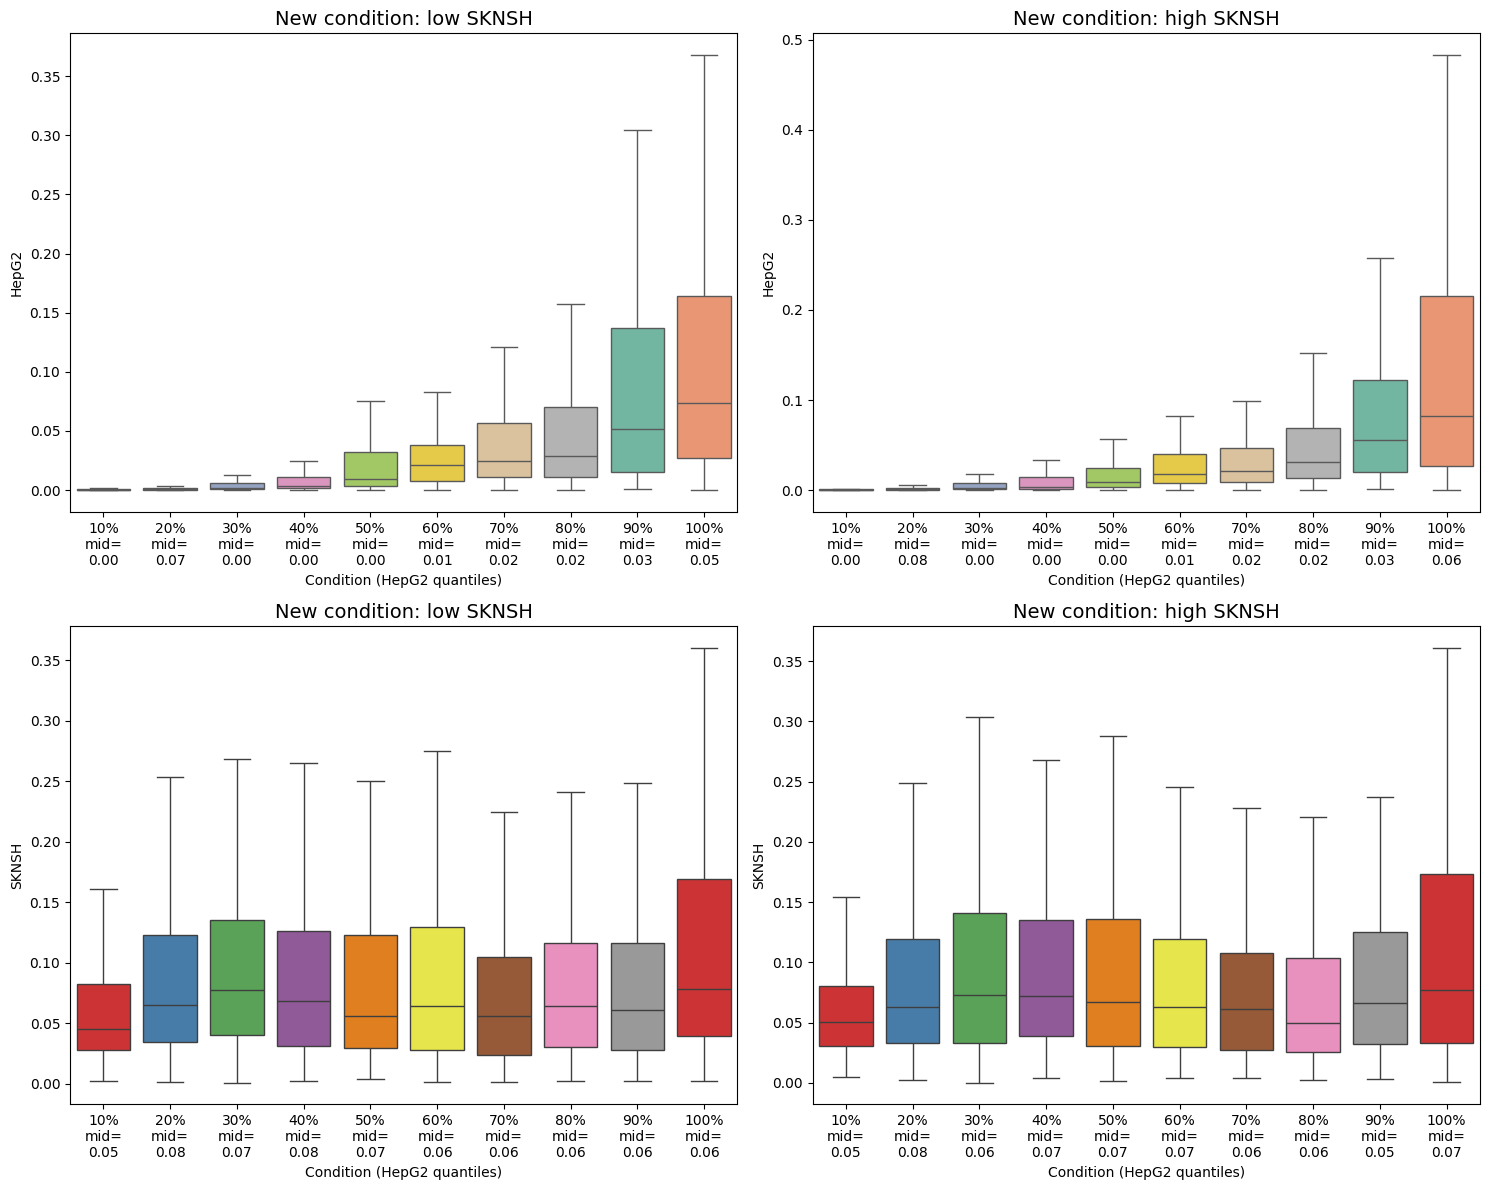

: 

In [88]:
# Prepare data for comparison and plotting

compare_hepg2_low = np.concatenate([rewards_conditions_low[i][:, 1].reshape(-1) for i in range(10)], axis=0)
compare_hepg2_high = np.concatenate([rewards_conditions_high[i][:, 1].reshape(-1) for i in range(10)], axis=0)
compare_sknsh_low = np.concatenate([rewards_conditions_low[i][:, 5].reshape(-1) for i in range(10)], axis=0)
compare_sknsh_high = np.concatenate([rewards_conditions_high[i][:, 5].reshape(-1) for i in range(10)], axis=0)

types = [f'{(i+1)*10}%' for i in range(10)]

types_flat_hepg2_low = [t for i, t in enumerate(types) for _ in range(len(rewards_conditions_low[i][:, 0]))]
types_flat_hepg2_high = [t for i, t in enumerate(types) for _ in range(len(rewards_conditions_high[i][:, 0]))]
types_flat_sknsh_low = [t for i, t in enumerate(types) for _ in range(len(rewards_conditions_low[i][:, 1]))]
types_flat_sknsh_high = [t for i, t in enumerate(types) for _ in range(len(rewards_conditions_high[i][:, 1]))]

# Data dictionaries for each subplot
data_dict_hepg2_low = {'Condition (HepG2 quantiles)': types_flat_hepg2_low, 'HepG2': compare_hepg2_low}
data_dict_hepg2_high = {'Condition (HepG2 quantiles)': types_flat_hepg2_high, 'HepG2': compare_hepg2_high}
data_dict_sknsh_low = {'Condition (HepG2 quantiles)': types_flat_sknsh_low, 'SKNSH': compare_sknsh_low}
data_dict_sknsh_high = {'Condition (HepG2 quantiles)': types_flat_sknsh_high, 'SKNSH': compare_sknsh_high}

# Create DataFrames for each plot
plot_data_hepg2_low = pd.DataFrame(data_dict_hepg2_low)
plot_data_hepg2_high = pd.DataFrame(data_dict_hepg2_high)
plot_data_sknsh_low = pd.DataFrame(data_dict_sknsh_low)
plot_data_sknsh_high = pd.DataFrame(data_dict_sknsh_high)

# Create a 2x2 figure for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# sns.boxplot(data=plot_data_hepg2_low, 
#             x='Condition (HepG2 quantiles)', 
#             y='HepG2', 
#             palette="Set2", 
#             showfliers=False, ax=axs[0, 0])
boxplot_with_median(plot_data_hepg2_low, 'Condition (HepG2 quantiles)', 'HepG2', 
                    ax=axs[0, 0], palette="Set2", showfliers=False)
axs[0, 0].set_title('New condition: low SKNSH', fontsize=14)
axs[0, 0].set_xlabel('Condition (HepG2 quantiles)')
axs[0, 0].set_ylabel('HepG2')

# sns.boxplot(data=plot_data_hepg2_high, 
#             x='Condition (HepG2 quantiles)', 
#             y='HepG2', 
#             palette="Set2", 
#             showfliers=False, ax=axs[0, 1])
boxplot_with_median(plot_data_hepg2_high, 'Condition (HepG2 quantiles)', 'HepG2', 
                    ax=axs[0, 1], palette="Set2", showfliers=False)
axs[0, 1].set_title('New condition: high SKNSH', fontsize=14)
axs[0, 1].set_xlabel('Condition (HepG2 quantiles)')
axs[0, 1].set_ylabel('HepG2')

# sns.boxplot(data=plot_data_sknsh_low, 
#             x='Condition (HepG2 quantiles)', 
#             y='SKNSH', 
#             palette="Set1", 
#             showfliers=False, ax=axs[1, 0])
boxplot_with_median(plot_data_sknsh_low, 'Condition (HepG2 quantiles)', 'SKNSH', 
                    ax=axs[1, 0], palette="Set1", showfliers=False)
axs[1, 0].set_title('New condition: low SKNSH', fontsize=14)
axs[1, 0].set_xlabel('Condition (HepG2 quantiles)')
axs[1, 0].set_ylabel('SKNSH')

# sns.boxplot(data=plot_data_sknsh_high, 
#             x='Condition (HepG2 quantiles)', 
#             y='SKNSH', 
#             palette="Set1", 
#             showfliers=False, ax=axs[1, 1])
boxplot_with_median(plot_data_sknsh_high, 'Condition (HepG2 quantiles)', 'SKNSH', 
                    ax=axs[1, 1], palette="Set1", showfliers=False)
axs[1, 1].set_title('New condition: high SKNSH', fontsize=14)
axs[1, 1].set_xlabel('Condition (HepG2 quantiles)')
axs[1, 1].set_ylabel('SKNSH')

plt.tight_layout()

# Save plot to a temporary file
# plot_file = os.path.join(save_folder_eval, f'boxplot_epoch_{k}.png')
# plt.savefig(plot_file)
plt.show()